In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


In [2]:
# Define the create_lstm_model function outside the loop
def create_lstm_model(learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [3]:
# Load and preprocess the data
df = pd.read_csv('2020Q1Q2Q3Q4-2021Q1 - Russia - Sberbank Rossii PAO (SBER).csv')
df = df[['Date', 'Price']]
df = df.drop(df.tail(1).index)
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(float)
df.sort_values(by='Date', ascending=True, inplace=True)
df.set_index('Date', inplace=True)

split_date = '2021-01-01'
train_data = df.loc[:split_date]
test_data = df.loc[split_date:]

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [4]:
seq_length = 10
X_train, y_train = [], []
for i in range(seq_length, len(train_scaled)):
    X_train.append(train_scaled[i-seq_length:i])
    y_train.append(train_scaled[i])

X_test, y_test = [], []
for i in range(seq_length, len(test_scaled)):
    X_test.append(test_scaled[i-seq_length:i])
    y_test.append(test_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)


In [5]:
len(X_train)
len(y_train)

240

In [6]:
param_grid = {'learning_rate': [0.001, 0.01, 0.1],
              'dropout_rate': [0.2, 0.4, 0.6]}
model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=32, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train, y_train)

<ipython-input-6-91025a0a841e>:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, epochs=100, batch_size=32, verbose=0)


In [7]:
# Get the best hyperparameters
best_params = grid_result.best_params_
learning_rate = best_params['learning_rate']
dropout_rate = best_params['dropout_rate']

In [8]:
# Ensemble model
num_models = 5  # Number of models in the ensemble
ensemble_predictions = np.zeros_like(y_test).reshape(-1)
ensemble_train_predictions = np.zeros_like(y_train).reshape(-1)

for i in range(num_models):
    model = create_lstm_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop], verbose=0)
    predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    ensemble_predictions += scaler.inverse_transform(predictions).flatten() / num_models
    ensemble_train_predictions += scaler.inverse_transform(train_predictions).flatten() / num_models


8/8 [==============================] - 0s 5ms/step


In [9]:
# Calculate RMSE
ensemble_rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), ensemble_predictions))
print('Ensemble RMSE:', ensemble_rmse)


Ensemble RMSE: 6.377527780774374


In [10]:
# Convert train_data and test_data to DataFrames
train_data_df = pd.DataFrame(train_data[seq_length:].values, columns=['Actual Train Prices'], index=train_data.index[seq_length:])
test_data_df = pd.DataFrame(test_data[seq_length:].values, columns=['Actual Test Prices'], index=test_data.index[seq_length:])

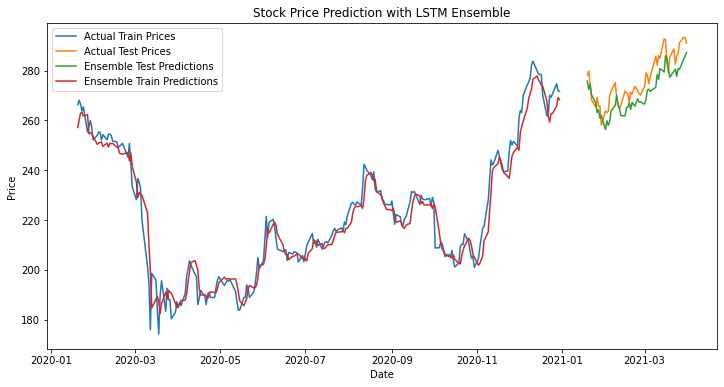

In [11]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, train_data_df['Actual Train Prices'], label='Actual Train Prices')
plt.plot(test_data_df.index, test_data_df['Actual Test Prices'], label='Actual Test Prices')
plt.plot(test_data_df.index, ensemble_predictions, label='Ensemble Test Predictions')
plt.plot(train_data_df.index, ensemble_train_predictions, label='Ensemble Train Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction with LSTM Ensemble')
plt.legend()
plt.show()

In [12]:
df_bollinger = df.copy()
df_bollinger = df_bollinger.reset_index()

# Calculate Bollinger Bands on predicted prices

sma = df_bollinger['Price'].rolling(window=20).mean()
rstd = df_bollinger['Price'].rolling(window=20).std()

upper_band = sma + 0.5 * rstd
lower_band = sma - 0.5 * rstd
    
    
df_bollinger['Upper'] = upper_band
df_bollinger['Lower'] = lower_band

dates_bollinger = df_bollinger['Date']


In [13]:
df_bollinger

,Date,Price,Upper,Lower
0,2020-01-03,255.00,NaN,NaN
1,2020-01-06,253.90,NaN,NaN
2,2020-01-08,259.15,NaN,NaN
3,2020-01-09,257.99,NaN,NaN
4,2020-01-10,258.19,NaN,NaN
...,...,...,...,...
306,2021-03-25,286.66,285.222580,278.739420
307,2021-03-26,291.22,286.118207,279.894793
308,2021-03-29,293.30,287.088202,281.237798
309,2021-03-30,293.25,287.959874,282.333126


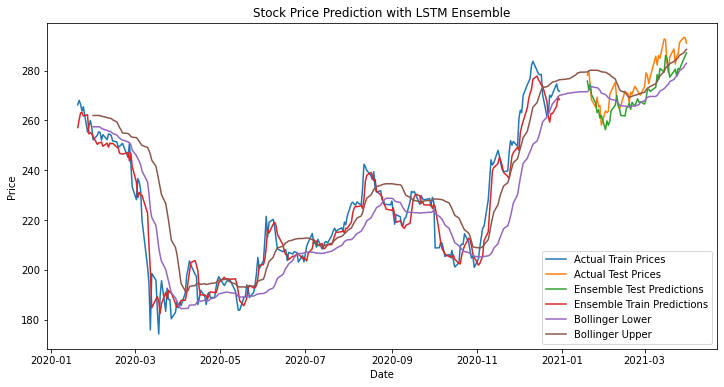

In [14]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data_df.index, train_data_df['Actual Train Prices'], label='Actual Train Prices')
plt.plot(test_data_df.index, test_data_df['Actual Test Prices'], label='Actual Test Prices')
plt.plot(test_data_df.index, ensemble_predictions, label='Ensemble Test Predictions')
plt.plot(train_data_df.index, ensemble_train_predictions, label='Ensemble Train Predictions')
plt.plot(dates_bollinger, lower_band, label= 'Bollinger Lower')
plt.plot(dates_bollinger, upper_band, label= 'Bollinger Upper')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction with LSTM Ensemble')
plt.legend()
plt.show()

### Using Bolinger Bands

In [15]:
prediction_df = test_data_df.copy()
prediction_df['Predicted Price'] = ensemble_predictions
prediction_df.reset_index(inplace=True)
prediction_df = prediction_df.merge(df_bollinger[['Date', 'Upper', 'Lower']], on='Date', how='inner',)

In [16]:
# Add a new column 'Recommendation' based on conditions
prediction_df['Recommendation'] = 'HOLD'  # Default recommendation

# Update the recommendation based on conditions
prediction_df.loc[prediction_df['Predicted Price'] < prediction_df['Lower'], 'Recommendation'] = 'BUY'
prediction_df.loc[prediction_df['Predicted Price'] > prediction_df['Upper'], 'Recommendation'] = 'SELL'
               
prediction_df

,Date,Actual Test Prices,Predicted Price,Upper,Lower,Recommendation
0,2021-01-19,278.19,275.821705,279.411412,271.498588,HOLD
1,2021-01-20,279.80,272.402649,279.870390,272.003610,HOLD
2,2021-01-21,274.40,274.454773,280.140263,272.994737,HOLD
3,2021-01-22,268.25,270.319160,280.175361,273.580639,BUY
4,2021-01-25,265.30,266.880898,280.104519,273.171481,BUY
5,2021-01-26,269.34,263.130669,280.104965,273.173035,BUY
6,2021-01-27,265.50,264.269798,280.008927,272.755073,BUY
7,2021-01-28,265.96,260.952003,279.752401,272.137599,BUY
8,2021-01-29,258.11,261.974617,279.534185,270.966815,BUY
9,2021-02-01,263.80,256.291199,279.314908,270.401092,BUY


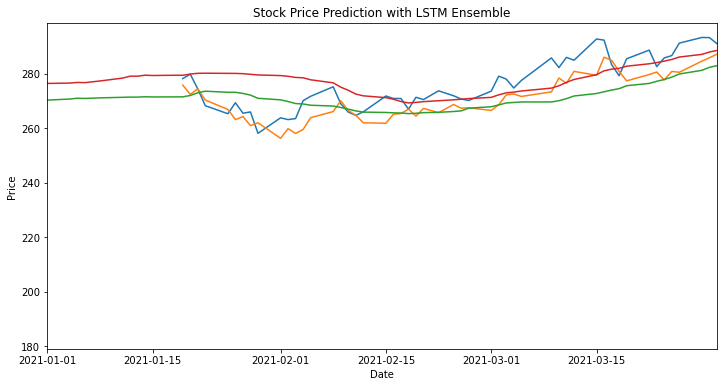

In [17]:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-03-31')

plt.figure(figsize=(12, 6))
plt.plot(test_data_df.index, test_data_df['Actual Test Prices'], label='Actual Test Prices')
plt.plot(test_data_df.index, ensemble_predictions, label='Ensemble Test Predictions')
plt.plot(dates_bollinger, lower_band, label= 'Bollinger Lower')
plt.plot(dates_bollinger, upper_band, label= 'Bollinger Upper')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Prediction with LSTM Ensemble')
plt.xlim(start_date, end_date)
plt.show()


- look at other prediction methods for buy sell hold.

### Using Local Maxima

In [18]:
def find_local_maxima(arr, start_pos):
    local_maxima = []
    highest_pos = start_pos

    for i in range(start_pos + 1, len(arr)):
        if arr[i] > arr[highest_pos]:
            highest_pos = i
        else:
            if i == start_pos + 1:  # If the first element is not a local maxima, move start_pos to the next element
                start_pos = i

            if highest_pos > start_pos:  # If a local maxima is found, append it to the list and move start_pos to the next element
                local_maxima.append((arr[highest_pos], highest_pos))
                start_pos = highest_pos

            highest_pos = start_pos

    if highest_pos > start_pos:  # Check if the last element is a local maxima
        local_maxima.append((arr[highest_pos], highest_pos))

    return local_maxima


def make_recommendations(predictions):
    recommendations = []
    holding = False 
    buying_price = 0.0
    local_maxima = []

    for i in range(len(predictions)):
        if not holding:
            if i == 0:
                recommendations.append("BUY")
                holding = True
                buying_price = predictions[i]
                local_maxima = find_local_maxima(predictions, i)
                if local_maxima:
                    highest_num, highest_pos = local_maxima[0]
            else:
                recommendations.append("BUY")
                holding = True
                buying_price = predictions[i]
                local_maxima = find_local_maxima(predictions, i)
                if local_maxima:
                    highest_num, highest_pos = local_maxima[0]

        else:
            if i == highest_pos:
                recommendations.append("SELL")
                holding = False
                buying_price = 0.0
                if local_maxima:
                    local_maxima.pop(0)  # Remove the current local maxima from the list
                    if local_maxima:
                        highest_num, highest_pos = local_maxima[0]  # Get the next local maxima, if available
            else:
                recommendations.append("HOLD")

    return recommendations

In [19]:
recommendations = make_recommendations(ensemble_predictions)
recommendation_df = pd.DataFrame({'Date': test_data_df.index,'Predicted Price': ensemble_predictions})
recommendation_df = recommendation_df.merge(df_bollinger[['Date', 'Upper', 'Lower']], on='Date', how='inner')
recommendation_df['Recommendation'] = recommendations
recommendation_df['Price Change'] = 0.0
holding = False
buying_price = 0.0

for i in range(len(recommendation_df)):
    if recommendation_df['Recommendation'][i] == 'BUY':
        holding = True
        buying_price = recommendation_df['Predicted Price'][i]
    elif recommendation_df['Recommendation'][i] == 'SELL':
        if holding:
            recommendation_df.loc[i, 'Price Change'] = recommendation_df['Predicted Price'][i] - buying_price
            holding = False
            
# Calculate the Cumulative Price Change column
recommendation_df['Cumulative Price Change'] = recommendation_df['Price Change'].cumsum()

recommendation_df

,Date,Predicted Price,Upper,Lower,Recommendation,Price Change,Cumulative Price Change
0,2021-01-19,275.821705,279.411412,271.498588,BUY,0.000000,0.000000
1,2021-01-20,272.402649,279.870390,272.003610,HOLD,0.000000,0.000000
2,2021-01-21,274.454773,280.140263,272.994737,SELL,-1.366932,-1.366932
3,2021-01-22,270.319160,280.175361,273.580639,BUY,0.000000,-1.366932
4,2021-01-25,266.880898,280.104519,273.171481,HOLD,0.000000,-1.366932
5,2021-01-26,263.130669,280.104965,273.173035,HOLD,0.000000,-1.366932
6,2021-01-27,264.269798,280.008927,272.755073,SELL,-6.049362,-7.416294
7,2021-01-28,260.952003,279.752401,272.137599,BUY,0.000000,-7.416294
8,2021-01-29,261.974617,279.534185,270.966815,SELL,1.022614,-6.393681
9,2021-02-01,256.291199,279.314908,270.401092,BUY,0.000000,-6.393681
